In [1]:
import kagglehub

In [2]:
# Download customer-personality-analysis dataset
customer_path = kagglehub.dataset_download("imakash3011/customer-personality-analysis")

print("Path to dataset files:", customer_path)

100%|██████████| 62.0k/62.0k [00:00<00:00, 7.31MB/s]

Extracting files...
Path to dataset files: C:\Users\shenz\.cache\kagglehub\datasets\imakash3011\customer-personality-analysis\versions\1


In [3]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import seaborn as sns

In [4]:
# columns in customer-personality-analysis dataset
# People
# ID: Customer's unique identifier
# Year_Birth: Customer's birth year
# Education: Customer's education level
# Marital_Status: Customer's marital status
# Income: Customer's yearly household income
# Kidhome: Number of children in customer's household
# Teenhome: Number of teenagers in customer's household
# Dt_Customer: Date of customer's enrollment with the company
# Recency: Number of days since customer's last purchase
# Complain: 1 if the customer complained in the last 2 years, 0 otherwise

# Products
# MntWines: Amount spent on wine in last 2 years
# MntFruits: Amount spent on fruits in last 2 years
# MntMeatProducts: Amount spent on meat in last 2 years
# MntFishProducts: Amount spent on fish in last 2 years
# MntSweetProducts: Amount spent on sweets in last 2 years
# MntGoldProds: Amount spent on gold in last 2 years

# Promotion
# NumDealsPurchases: Number of purchases made with a discount
# AcceptedCmp1: 1 if customer accepted the offer in the 1st campaign, 0 otherwise
# AcceptedCmp2: 1 if customer accepted the offer in the 2nd campaign, 0 otherwise
# AcceptedCmp3: 1 if customer accepted the offer in the 3rd campaign, 0 otherwise
# AcceptedCmp4: 1 if customer accepted the offer in the 4th campaign, 0 otherwise
# AcceptedCmp5: 1 if customer accepted the offer in the 5th campaign, 0 otherwise
# Response: 1 if customer accepted the offer in the last campaign, 0 otherwise

# Place
# NumWebPurchases: Number of purchases made through the company’s website
# NumCatalogPurchases: Number of purchases made using a catalogue
# NumStorePurchases: Number of purchases made directly in stores
# NumWebVisitsMonth: Number of visits to company’s website in the last month

customer_data_file = customer_path + "/marketing_campaign.csv"
customer_df = pd.read_csv(customer_data_file, sep="\t")
print("Shape:", customer_df.shape)
customer_df.head(10)

Shape: (2240, 29)


,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0
5,7446,1967,Master,Together,62513.0,0,1,09-09-2013,16,520,...,6,0,0,0,0,0,0,3,11,0
6,965,1971,Graduation,Divorced,55635.0,0,1,13-11-2012,34,235,...,6,0,0,0,0,0,0,3,11,0
7,6177,1985,PhD,Married,33454.0,1,0,08-05-2013,32,76,...,8,0,0,0,0,0,0,3,11,0
8,4855,1974,PhD,Together,30351.0,1,0,06-06-2013,19,14,...,9,0,0,0,0,0,0,3,11,1
9,5899,1950,PhD,Together,5648.0,1,1,13-03-2014,68,28,...,20,1,0,0,0,0,0,3,11,0


In [5]:

# drop missing value
customer_df = customer_df.dropna()
# process date and time
customer_df['Dt_Customer'] = pd.to_datetime(customer_df['Dt_Customer'], dayfirst=True)
customer_df['Age'] = 2025 - customer_df['Year_Birth']
customer_df['Customer_days'] = (pd.to_datetime('2025-11-15') - customer_df['Dt_Customer']).dt.days
# encode categorical vars
education_order = ['Basic', 'Graduation', 'Master', '2n Cycle', 'PhD']
value_to_code = {value: i for i, value in enumerate(education_order)}
customer_df['education_encoded'] = customer_df['Education'].map(value_to_code)
mapping = lambda x: 0 if x in ['Together', 'Married'] else 1
customer_df['alone_encoded'] = customer_df['Marital_Status'].apply(mapping)
# sum
customer_df['num_child'] = customer_df['Kidhome'] + customer_df['Teenhome']
customer_df['spend'] = customer_df['MntFishProducts'] + customer_df['MntFruits'] + customer_df['MntGoldProds'] + customer_df['MntWines'] + customer_df['MntMeatProducts'] + customer_df['MntSweetProducts']
customer_df['num_cmp_accepted'] = customer_df['AcceptedCmp1'] + customer_df['AcceptedCmp2'] + customer_df['AcceptedCmp3'] + customer_df['AcceptedCmp4'] + customer_df['AcceptedCmp5'] + customer_df['Response']
# drop columns
customer_df_encoded = customer_df.drop(columns=['Dt_Customer', 'Year_Birth', 'Z_CostContact', 'Z_Revenue', 'ID', 'Marital_Status', 'Education', 'AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Response', 'NumWebVisitsMonth', 'Kidhome', 'Teenhome', 'MntFishProducts', 'MntFruits', 'MntGoldProds', 'MntWines', 'MntMeatProducts', 'MntSweetProducts'])

In [ ]:
display(customer_df_encoded.describe().T)

,count,mean,std,min,25%,50%,75%,max
Income,2216.0,52247.251354,25173.076661,1730.0,35303.0,51381.5,68522.0,666666.0
Recency,2216.0,49.012635,28.948352,0.0,24.0,49.0,74.0,99.0
NumDealsPurchases,2216.0,2.323556,1.923716,0.0,1.0,2.0,3.0,15.0
NumWebPurchases,2216.0,4.085289,2.740951,0.0,2.0,4.0,6.0,27.0
NumCatalogPurchases,2216.0,2.671029,2.926734,0.0,0.0,2.0,4.0,28.0
NumStorePurchases,2216.0,5.800993,3.250785,0.0,3.0,5.0,8.0,13.0
Complain,2216.0,0.009477,0.096907,0.0,0.0,0.0,0.0,1.0
Age,2216.0,56.179603,11.985554,29.0,48.0,55.0,66.0,132.0
Customer_days,2216.0,4510.521209,202.434667,4157.0,4337.0,4512.5,4686.0,4856.0
education_encoded,2216.0,1.972022,1.248795,0.0,1.0,1.0,3.0,4.0


In [ ]:
customer_df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2216 entries, 0 to 2239
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Income               2216 non-null   float64
 1   Recency              2216 non-null   int64  
 2   NumDealsPurchases    2216 non-null   int64  
 3   NumWebPurchases      2216 non-null   int64  
 4   NumCatalogPurchases  2216 non-null   int64  
 5   NumStorePurchases    2216 non-null   int64  
 6   Complain             2216 non-null   int64  
 7   Age                  2216 non-null   int64  
 8   Customer_days        2216 non-null   int64  
 9   education_encoded    2216 non-null   int64  
 10  alone_encoded        2216 non-null   int64  
 11  num_child            2216 non-null   int64  
 12  spend                2216 non-null   int64  
 13  num_cmp_accepted     2216 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 259.7 KB


In [6]:
# normalize the data
mean = customer_df_encoded.mean()
std = customer_df_encoded.std()
customer_df_encoded_centered = (customer_df_encoded - mean) / std

In [7]:
# PCA keep at least 80% percent of variance
pca = PCA(n_components=8, random_state=42)
X_pca = pca.fit_transform(customer_df_encoded_centered)
print("Explained variance by 8 PCs:", pca.explained_variance_ratio_.sum())


Explained variance by 8 PCs: 0.8075298227201944


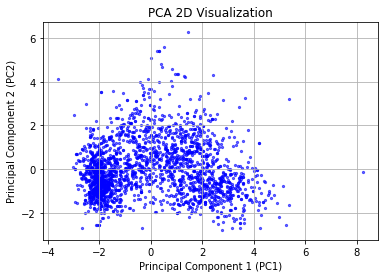

In [8]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], s=5, alpha=0.6, c='blue')
plt.xlabel('Principal Component 1 (PC1)')
plt.ylabel('Principal Component 2 (PC2)')
plt.title('PCA 2D Visualization')
plt.grid(True)
plt.show()

No handles with labels found to put in legend.


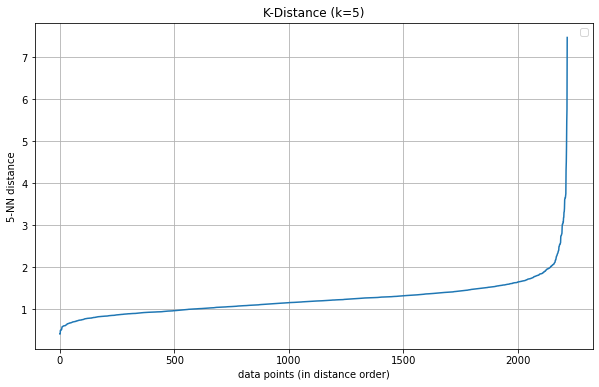

In [9]:
#DBSCAN

# find the optimal radius
from sklearn.neighbors import NearestNeighbors
k = 5
neighbors = NearestNeighbors(n_neighbors=k)
neighbors.fit(X_pca)
distances, indices = neighbors.kneighbors(X_pca)

# the kth nearest neighbor
k_distances = distances[:, -1]
k_distances = np.sort(k_distances)

plt.figure(figsize=(10, 6))
plt.plot(k_distances)
plt.xlabel('data points (in distance order)')
plt.ylabel(f'{k}-NN distance')
plt.title(f'K-Distance (k={k})')
plt.grid(True)
plt.legend()
plt.show()

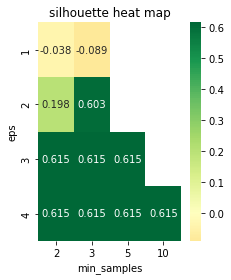

In [10]:
# grid search for the optimal parameter combination
eps_range = [1, 2, 3, 4]
min_samples_range = [2, 3, 5, 10]
best_params = None
best_score = -1
results_summary = []

for eps in eps_range:
  for ms in min_samples_range:
      dbscan = DBSCAN(eps=eps, min_samples=ms)
      labels = dbscan.fit_predict(X_pca)

      n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
      n_noise = list(labels).count(-1)

      if n_clusters >= 2 and n_noise < len(labels) * 0.5:
          mask = labels != -1
          if mask.sum() > 0 and len(set(labels[mask])) > 1:
              score = silhouette_score(X_pca[mask], labels[mask])

              results_summary.append({
                  'eps': eps,
                  'min_samples': ms,
                  'n_clusters': n_clusters,
                  'noise_ratio': n_noise / len(labels),
                  'silhouette': score
              })

              if score > best_score:
                  best_score = score
                  best_params = {'eps': eps, 'min_samples': ms}

plt.subplot(1, 2, 2)
df_results = pd.DataFrame(results_summary)
if len(df_results) > 0:
    pivot = df_results.pivot_table(
        values='silhouette',
        index='eps',
        columns='min_samples'
    )
    sns.heatmap(pivot, annot=True, fmt='.3f', cmap='RdYlGn', center=0)
    plt.title('silhouette heat map')

plt.tight_layout()
plt.show()

In [11]:
dbscan = DBSCAN(eps=3, min_samples=5)
labels = dbscan.fit_predict(X_pca)

print(f"number of cluster: {len(set(labels)) - (1 if -1 in labels else 0)}")
print(f"noise %: {list(labels).count(-1) / len(labels):.2%}")

number of cluster: 2
noise %: 0.54%


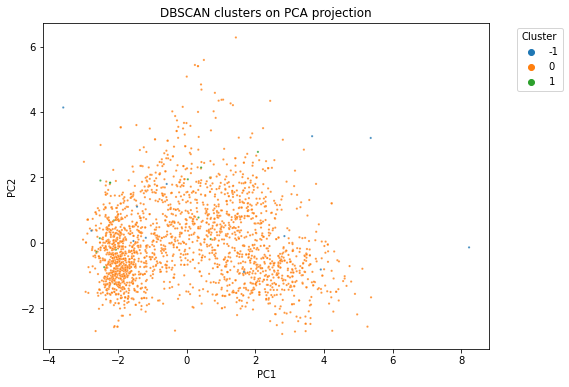

DBSCAN silhouette score: 0.6145348042842957
DBSCAN calinski_harabasz_score: 158.45153573334966
DBSCAN davies_bouldin_score: 0.5496976969145358


In [13]:
plt.figure(figsize=(8,6))
palette = sns.color_palette('tab10', 3)
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=labels, palette=palette, s=5, alpha=0.8, legend='full')
plt.title(f"DBSCAN clusters on PCA projection")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.legend(title='Cluster', bbox_to_anchor=(1.05,1), loc='upper left')
plt.show()

# silhouette score
mask = labels != -1
print("DBSCAN silhouette score:", silhouette_score(X_pca[mask], labels[mask]))
print("DBSCAN calinski_harabasz_score:", calinski_harabasz_score(X_pca[mask], labels[mask]))
print("DBSCAN davies_bouldin_score:", davies_bouldin_score(X_pca[mask], labels[mask]))